## ML Contest

Практическим проектом нашего курса будет анализ активности студентов онлайн курса [Введение в анализ данных в R](https://stepik.org/course/129/syllabus), спасибо команде stepik, что предоставили анонимизированные данные.

В этом модуле, мы разберемся с задачей, начнем исследовать данные, а об условиях соревнований, призах и тайных стэпах раскажу во втором модуле!

Описание данных:

[events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - данные о действиях, которые совершают студенты со стэпами

**step_id** - id стэпа<br>
**user_id** - анонимизированный id юзера<br>
**timestamp** - время наступления события в формате unix date<br>
**action** - событие, возможные значения: <br>
- discovered - пользователь перешел на стэп<br>
- viewed - просмотр шага,<br>
- started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага<br>
- passed - удачное решение практического шага<br>

[submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - данные о времени и статусах сабмитов к практическим заданиям

**step_id** - id стэпа
**timestamp** - время отправки решения в формате unix date
**submission_status** - статус решения
**user_id** - анонимизированный id юзера

In [190]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (9, 6)})
event_df = pd.read_csv("event_data_train.zip", compression='zip')
submissions_df = pd.read_csv("submissions_data_train.csv")
event_df.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


### Предварительный анализ уникальных посещений

Создадим дополнительные колонки **date** и **day**, в которых разместим удобоваримые даты посещений сайта. В качестве исходных данных возьмём колонку **timestamp**.

Выведем график уников, используя полученные значения в колонке **day**:

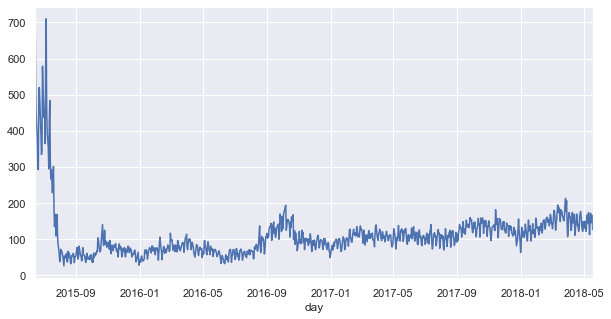

In [169]:
event_df['date'] = pd.to_datetime(event_df.timestamp, unit='s')
event_df['day'] = event_df.date.dt.date
event_df.groupby('day').user_id.nunique().plot(figsize=(10,5))

### Проанализируем соотношение пользователей к количеству решенных шагов

Для фильтрации будем использовать тип **action** 'passed'

In [170]:
event_df[event_df.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id':'count'}) \
    .rename(columns={'step_id':'passed_steps'}).head()

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


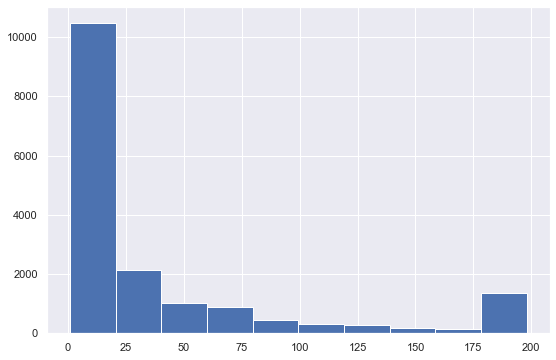

In [171]:
event_df[event_df.action == 'passed'] \
    .groupby('user_id', as_index=False) \
    .agg({'step_id':'count'}) \
    .rename(columns={'step_id':'passed_steps'}).passed_steps.hist()

Гистограмма выше не учитывает пользователей, у которых нет ни одного решенного шага. Для исправления ситуации, развернем исходные данные с использованием pivot_table, автоматически заполнив NaN-значения нулями.

Полученная гистограмма более точно отражает ситуацию с пользователями.

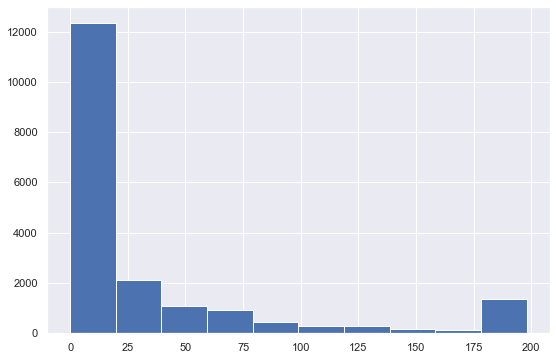

In [172]:
event_df.pivot_table(index='user_id',
               columns='action',
               values='step_id',
               aggfunc='count',
               fill_value=0).passed.hist()

Данные, с которыми мы работаем, обезличены, тоесть реальные id пользователей заменены случайным числом. Анонимизация пользовательских данных - очень важная тема для Data Science. С одной стороны мы хотим знать о поведении наших пользователей как можно больше, с другой стороны нам важно соблюдать приватность наших пользователей.

Поэтому данные о поведении пользователей анонимизируют не только когда речь идет об открытых данных, но и при работе с данными внутри компании. Не заметили сколько писем вам недавно пришло об изменении политики конфеденциальности, хотите узнать почему? В комментарии приложена ссылка на очень интересный доклад об этой проблеме.

А пока что вот вам хакерская задача, за каким вымышленным id скрывается Анатолий Карпов - автор курса, данные которого мы анализируем?

Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train.

In [173]:
submissions_df.query("submission_status == 'correct'") \
    .groupby('user_id').count() \
    .sort_values('submission_status', ascending=False).head()

,step_id,timestamp,submission_status
user_id,,,
1046,421,421,421
5552,186,186,186
17135,168,168,168
6183,142,142,142
8461,135,135,135


Предположение о том, что у автора курсов больше всех сабмитов со статусом 'correct', оказалось верным - его user_id = 1046.

## Вычисление 'отвалившихся' пользователей

Отвалившимися от прохождения курса будем считать тех, у кого гэп между датой (timestamp) самого последнего посещения в events_train и максимальной последней датой самого юзера больше одного месяца.

In [189]:
# гэп в секундах
month_gap = 30 * 24 * 60 * 60

# максимальный timestamp для events_train
max_timestamp = df['timestamp'].max()
event_df.head()
# вычисляем максимальные timestamps для юзеров
users_data = event_df.groupby('user_id', as_index=False).agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
#users_data = users_data.query("@max_timestamp - last_timestamp > @month_gap")
users_data["is_gone_user"] = (max_timestamp - users_data.last_timestamp) > month_gap

# сколько у юзера было данных, для которых был правильный correct submit
users_scores = submissions_df.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()
users_scores.head()
# мерджим данные с использованием outer join, чтобы не упустить юзеров которые вообще не делали сабмитов
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0)

# прикрутим данные и про остальные события.
users_events_data = event_df.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

users_data = users_data.merge(users_events_data, how='outer')

#сколько уникальных дней пользователь был в сервисе.
users_days = event_df.groupby('user_id').day.nunique().to_frame().reset_index()

# прикручиваем
user_data = users_data.merge(users_days, how='outer')

# показатель того, что пользователь успешно закончил курс.
# Например, пользователь набрал более 175 пройденных шагов.
users_data['passed_course'] = users_data.passed > 175

users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,False


In [143]:
# Проверяем, что мы никого не потеряли, смотрим на количество юзеров.
user_data.user_id.nunique()

19234

In [146]:
event_df.user_id.nunique()

19234